In [106]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns
import wtascripts.wta_helpers as wta_helpers

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

import warnings
warnings.simplefilter('ignore')

In [63]:
# Sklearn specific imports
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MultiLabelBinarizer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [64]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
plt.rcParams['figure.figsize'] = (8,5)

In [73]:
# Load then clean dataset
df = wta_helpers.load_raw_df()
df = wta_helpers.clean_raw_df(df, minvotes=4)

## Helper Functions

In [72]:
def residual_plot(y_pred, y_train):
    res = y_train - y_pred
    plt.scatter(y_pred, res, s=3)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    return plt.show();

## Plan of Action
* Use multi-label binarizer :  fee column
* Use label binarizer : region
* Probably remove votes or countreports due to collinearity. Which one is better? I think votes is bad too due to direct tie to trail
  * A better model wouldn't have votes or count of reports - because those are not trail features

#### Questions/ Flaws:
* With MLB I'm not accounting for parks that have multiple fees . I could simplify by saying fee or no fee? 

### Preprocessing

In [86]:
onehot_feats = ['Wildflowers/Meadows', 'Ridges/passes',
'Wildlife','Waterfalls','Old growth','Summits','Good for kids','Dogs allowed on leash',
'Fall foliage','Lakes','Rivers','Coast','Mountain views','Established campsites',]
# Not used: lat, long, subregion, lengthtype

cont_feats = ['votes', 'countreports', 'length', 'gain', 'hpoint']
# cont_feats = ['votes', 'length', 'gain', 'hpoint']
# cont_feats = ['length', 'gain', 'hpoint']

oh_cols = df[onehot_feats]

#Standardize the non one-hot encoding variables into XS
s = StandardScaler()
XS = s.fit_transform(df[cont_feats])
#print(oh_cols)
# combine with the one hot encoding variables

# multilabelbinarizer for 'fees' column
mlb = MultiLabelBinarizer()
fees_processed = mlb.fit_transform(df['fee'].str.replace(", ",",").str.split(","))

# labelbinarizer for 'region' column
lb = LabelBinarizer()
region_processed = lb.fit_transform(df['region'])

# X = np.concatenate([XS, oh_cols, fees_processed, region_processed], axis=1) ## All features
# X = np.concatenate([oh_cols, fees_processed, region_processed], axis=1) ## Remove continuous features
# X = np.concatenate([XS], axis=1) ## Only continuous features

# y = df['rating'] # SEE BELOW - I NOW MADE y and X OFF A PANDAS DATAFRAME

# This code makes a DF of my transformed variables. There is some weird stuff in there with neg lengths...
y2 = y[:,np.newaxis]
XSpecial = np.concatenate([X, y2], axis=1)
df_model = pd.DataFrame(XSpecial, columns= (cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) + ['rating']))

y = df_model['rating']
X = df_model.iloc[:,:-1]

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [93]:
# This code makes a DF of my transformed variables. There is some weird stuff in there with neg lengths...
y2 = y[:,np.newaxis]
XSpecial = np.concatenate([X, y2], axis=1)
df_model = pd.DataFrame(XSpecial, columns= (cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) + ['rating']))

In [100]:
y = df_model['rating']
X = df_model.iloc[:,:-1]

# Test Train Split

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Test Suite

In [107]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print("LinReg - Poly 1")
print("Train R^2:", lr.score(X_train, y_train))
print("")

poly_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_lr.fit(X_train, y_train)
print("LinReg - Poly 2")
print("Train R^2:", poly_lr.score(X_train, y_train))
print("")

lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
print("LassoCV - Poly 1")
print("Train R^2:", lasso.score(X_train, y_train))
print("")

poly_lasso = make_pipeline(PolynomialFeatures(2), LassoCV(cv=5))
poly_lasso.fit(X_train, y_train)
print("LassoCV - Poly 2")
print("Train R^2:", poly_lasso.score(X_train, y_train))
print("")

ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
print("RR - Poly 1")
print("Train R^2:", ridge.score(X_train, y_train))

poly_ridge = make_pipeline(PolynomialFeatures(2), RidgeCV())
poly_ridge.fit(X_train, y_train)
print("RR - Poly 2")
print("Train R^2:", poly_ridge.score(X_train, y_train))

LinReg - Poly 1
Train R^2: 0.23892057643514641

LinReg - Poly 2
Train R^2: 0.7393456819238176

LassoCV - Poly 1
intercept: 3.267422209696455
Train RMSE: 0.5877781810442652
Train MSE: 0.345483190111705
Train R^2: 0.22536128610216777

LassoCV - Poly 2
Train R^2: 0.2773378168789331

RR - Poly 1
Train R^2: 0.23444143601069511
RR - Poly 2
Train R^2: 0.5580463106318245


# Linear Regression

In [118]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print("intercept:",lr.intercept_)
# print("coefficients,",lr.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lr.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Train R^2:", lr.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))z
# print('Test SSE:', mean_squared_error(y_test, lr.predict(X_test)))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(lr.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.644554982932296
Train RMSE: 0.5836812916669851
Train MSE: 0.3406838502420401
Train R^2: 0.25731415806183133




In [119]:
"""Polynomial with LinearRegression"""

poly_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_lr.fit(X_train, y_train)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_lr.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lr.predict(X_train)))
print("Train R^2:", poly_lr.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_lr.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_lr.predict(X_test)))
print('Test R^2: ', poly_lr.score(X_test, y_test))
print('Test SSE:', mean_squared_error(y_test, poly_lr.predict(X_test)))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_lr.coef_,3)), key=lambda x: x[1], reverse=True))

Train RMSE: 0.36903699200937684
Train MSE: 0.13618830147132888
Train R^2: 0.7031114821894138

Test RMSE: 2.1671079090148733
Test MSE: 4.696356689314816
Test R^2:  -10.307321931573515
Test SSE: 4.696356689314816



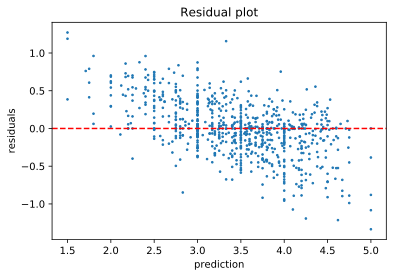

In [120]:
# plot of poly_lr
residual_plot(y_train, poly_lr.predict(X_train))

#### Tips from Chad on what I can do now:
* Plot whatever feats I want to explore vs residuals
* Look for patterns in data
* If I am missing data in a certain area of my predicted vs actual plots, then take subset and look there
* plot sum /log / function of the categorical features, vs residuals.

##### Once I find a pattern and want to Feat Eng., then add a new column to my X data array.

In [ ]:
for col in df_model.columns:
    plt.plot(y=i)

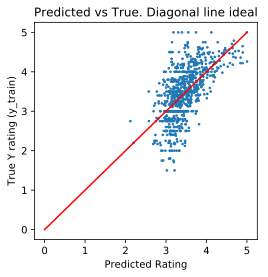

In [80]:
plt.figure(figsize=(4,4))
plt.scatter(poly_lr.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.title("Predicted vs True. Diagonal line ideal")
plt.plot(range(6), c='r');

# Lasso

In [51]:
#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,10,100]
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
print("intercept:",lasso.intercept_)
# print("coefficients,",lasso.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, lasso.predict(X_train)))
print("Train R^2:", lasso.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))
# print('Test SSE:', mean_squared_error(y_test, lasso.predict(X_test)))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(lasso.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.279826563006522
Train RMSE: 0.5914515015343493
Train MSE: 0.3498148786672365
Train R^2: 0.226538025759902




In [54]:
"""Polynomial with LassoCV"""

#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
poly_lasso = make_pipeline(PolynomialFeatures(2), LassoCV(cv=5))
poly_lasso.fit(X_train, y_train)
#print("intercept:",poly_lasso.intercept_)
# print("coefficients,",poly_lasso.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_lasso.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lasso.predict(X_train)))
print("Train R^2:", poly_lasso.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))
# print('Test SSE:', mean_squared_error(y_test, poly_lasso.predict(X_test)))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_lasso.coef_,3)), key=lambda x: x[1], reverse=True))

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Train RMSE: 0.5870261506002394
Train MSE: 0.344599701488535
Train R^2: 0.2380690997154139




/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


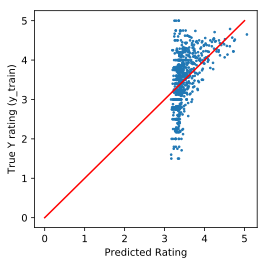

In [56]:
plt.figure(figsize=(4,4))
plt.scatter(poly_lasso.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.plot(range(6), c='r');

# Ridge Regression

In [113]:
#Straight Ridge Regression

#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
print("intercept:",ridge.intercept_)
# print("coefficients,",ridge.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, ridge.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, ridge.predict(X_train)))
print("Train R^2:", ridge.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))
# print('Test SSE:', mean_squared_error(y_test, ridge.predict(X_test)))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(ridge.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.3137729571417514
Train RMSE: 0.5843231210458175
Train MSE: 0.34143350978872505
Train R^2: 0.23444143601069511




In [116]:
"""Polynomial with RidgeCV"""

#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
poly_ridge = make_pipeline(PolynomialFeatures(2), RidgeCV(cv=5))
poly_ridge.fit(X_train, y_train)
#print("intercept:",poly_ridge.intercept_)
# print("coefficients,",poly_ridge.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_ridge.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_ridge.predict(X_train)))
print("Train R^2:", poly_ridge.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_ridge.predict(X_test))))
# print("Test MSE:", metrics.mean_squared_error(y_test, poly_ridge.predict(X_test)))
# print('Test R^2: ', poly_ridge.score(X_test, y_test))
# print('Test SSE:', mean_squared_error(y_test, poly_ridge.predict(X_test)))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_ridge.coef_,3)), key=lambda x: x[1], reverse=True))

Train RMSE: 0.4439685878226051
Train MSE: 0.19710810697319822
Train R^2: 0.558046310631825

Test RMSE: 0.6382730265433585
Test MSE: 0.40739245641281885
Test R^2:  0.10525964933342813
Test SSE: 0.40739245641281885



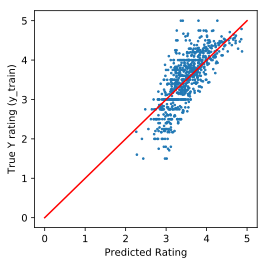

In [59]:
plt.figure(figsize=(4,4))
plt.scatter(poly_ridge.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.plot(range(6), c='r');

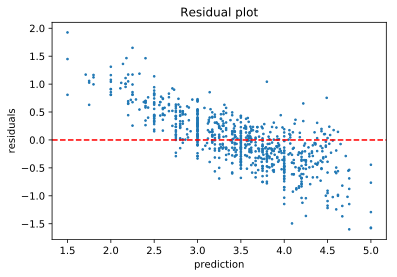

In [121]:
residual_plot(y_train, poly_ridge.predict(X_train))

# Feature Engineering and EDA

# Plots

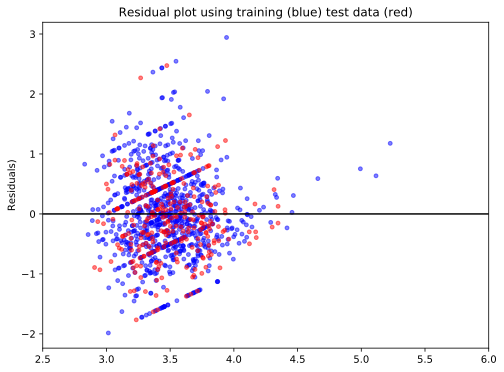

In [15]:
plt.figure(figsize = (8,6))
plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train, c='b', s=15, alpha=0.5)
plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test, c='r', s=15, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=50)
plt.xlim(2.5,6)
plt.title("Residual plot using training (blue) test data (red)")
plt.ylabel("Residuals)");

In [ ]:
# try rating = log(votes), log(countreports)

In [61]:
sns.pairplot(df_special, y_vars = 'rating', x_vars = df_special.columns[:-1]);

In [ ]:
sns.pairplot(df, y_vars = 'rating', x_vars= cont_feats);

In [ ]:
# votes, count of tripreports, mountains, waterfall, summits, then hpoint, then ridges/passes

In [ ]:
# sns.pairplot(df[(df.votes > 3) & (df.length < 60) & (df.hpoint < 9000)],
#              x_vars=['votes','length','gain','hpoint','countreports'],
#              y_vars='rating')

In [ ]:
# # votes and count reports are highly correlated
# plt.scatter(df['votes'], df['countreports']);